In [1]:
#ABILITà Informatiche
#dati Veneto blocco 21

In [1]:
import numpy as np
import imageio
import matplotlib
import scipy
from scipy.optimize import minimize
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
import json
import emcee
%matplotlib notebook

In [2]:
indata = open('dpc-covid19-ita-regioni.json')
dati = json.load(indata)

In [3]:
dati[20]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 5,
 'denominazione_regione': 'Veneto',
 'lat': 45.43490485,
 'long': 12.33845213,
 'ricoverati_con_sintomi': 12,
 'terapia_intensiva': 4,
 'totale_ospedalizzati': 16,
 'isolamento_domiciliare': 16,
 'totale_positivi': 32,
 'variazione_totale_positivi': 0,
 'nuovi_positivi': 32,
 'dimessi_guariti': 0,
 'deceduti': 1,
 'casi_da_sospetto_diagnostico': None,
 'casi_da_screening': None,
 'totale_casi': 33,
 'tamponi': 2200,
 'casi_testati': None,
 'note': None,
 'ingressi_terapia_intensiva': None,
 'note_test': None,
 'note_casi': None,
 'totale_positivi_test_molecolare': None,
 'totale_positivi_test_antigenico_rapido': None,
 'tamponi_test_molecolare': None,
 'tamponi_test_antigenico_rapido': None,
 'codice_nuts_1': None,
 'codice_nuts_2': None}

In [4]:
len(dati)

21252

In [5]:
data_tot = []
casi_tot = []

for i in range(1012):
    data_tot.append(dati[20 + i*21]['data'])
    casi_tot.append(dati[20 + i*21]['totale_casi'])

<IPython.core.display.Javascript object>


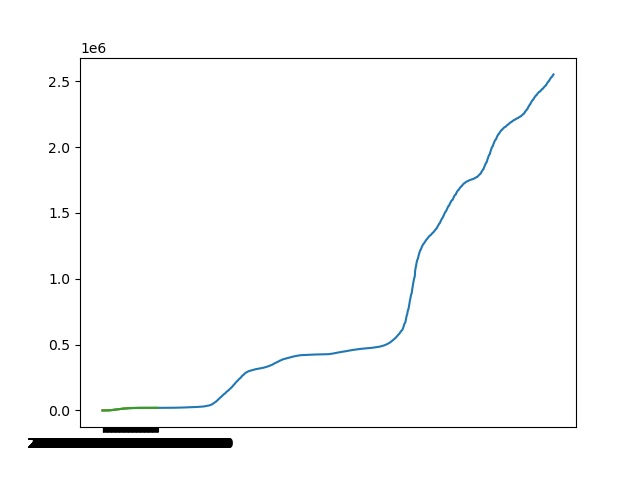

In [6]:
plt.figure()
plt.plot(casi_tot)

In [10]:
data = []
casi = []
N = 125

for i in range(N):
    data.append(dati[20 + i*21]['data'])
    casi.append(dati[20 + i*21]['totale_casi'])
    
plt.plot(data, casi)


In [11]:
#funzione di gompertz

In [12]:
def gompertz(N, t0, ni, b):
    '''
    calcolo della funzione di gompertz per N punti con t0 tempo di inizio, ni plateau della popolazione/dimensione popolazione, 
    b rate di crescita iniziale e n0 popolazione iniziale
    output funzione di gompertz e funzione di gompertz differenziale
    '''
    gomp = np.zeros(N)
    k = np.log(ni)
    for t in range(N):
        gomp[t] = np.exp( k * ( 1 - np.exp( -b * (t-t0) ) ) )

    gomp_diff = np.zeros(N-1)
    for t in range(N-1):
            gomp_diff[t] = gomp[t+1] - gomp[t]
            
    return gomp, gomp_diff

<IPython.core.display.Javascript object>


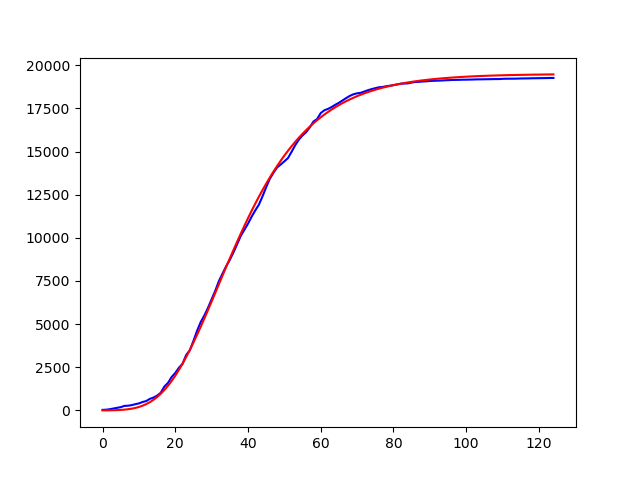

In [13]:
#prova con casi
t0 = -1
b = 0.07
ni = 19500

prova, diff = gompertz(N, t0, ni, b)

dati_casi = [x for x in casi]

plt.figure()
plt.plot(dati_casi, color='blue')
plt.plot(prova, color='red')

In [14]:
#poisson likelihood

In [15]:
def log_likelihood(dati, predizione):
    '''
    calcolo del logaritmo poisson-likelihood per i dati usando come modello predizione (entrambi array) 
    '''
    # -log(likelihood) = L
    L = -np.sum(-np.log(predizione)*dati + predizione )
        
    # non c'è fattoriale perchè non serve per minimizzare (log(dati[i]!) non dipende dal modello)
    return L

<IPython.core.display.Javascript object>


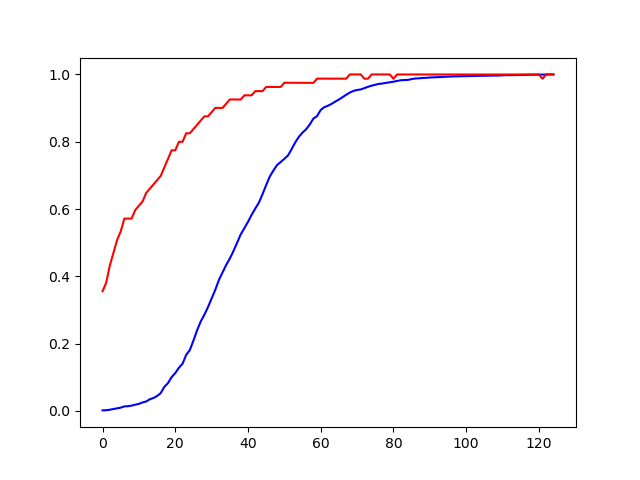

In [16]:
#prova casi
stima = prova

sol = minimize(log_likelihood, stima, dati_casi)

dati_nor = [x/max(dati_casi) for x in dati_casi]

sol_nor = sol.x/min(sol.x)

plt.figure()
plt.plot(dati_nor, color='blue')
plt.plot(sol_nor, color='red')

In [17]:
#emcee guida(https://emcee.readthedocs.io/en/stable/)

In [18]:
def log_likelihood_gompertz(theta, dati):
    '''
    calcolo del logaritmo poisson-likelihood per i dati (array) usando come modello la funzione di gompertz (vedi fun gompertz) 
    '''
    t0, ni, b = theta
    N = len(dati)
    modello, dif = gompertz(N, t0, ni, b)
    modello = modello + .01
    
    # -log(likelihood) = L
    L = -np.sum(dati*np.log(modello) - modello )   
    # non c'è fattoriale perchè non serve per minimizzare (log(dati[i]!) non dipende dal modello)
    
    return L

-4 19444.602990998545 0.3081575017841919


<IPython.core.display.Javascript object>


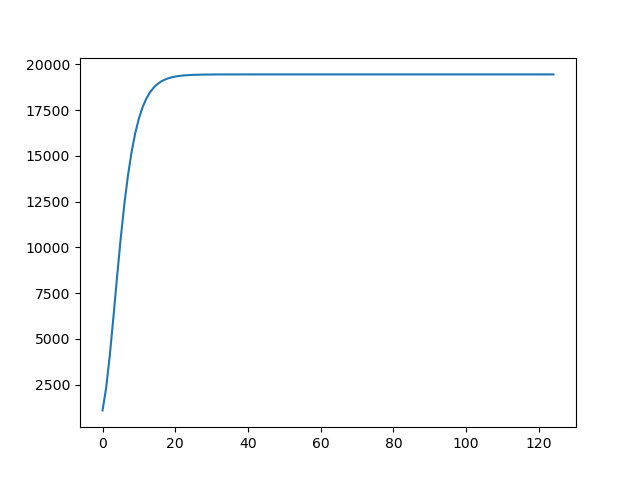

In [19]:
#np.random.seed(7)
t0 = -np.random.randint(0, 5)
ni = max(casi) + 500 * np.random.uniform(-1,1)
b = np.random.uniform()

modello, diff_modello = gompertz(N, t0, ni, b)

print(t0, ni, b)

plt.figure()
plt.plot(modello)

[-4.25078710e+00  1.96198635e+04  6.37445059e-02]
[-4.00000000e+00  1.88327397e+04  9.49730518e-02]


<IPython.core.display.Javascript object>


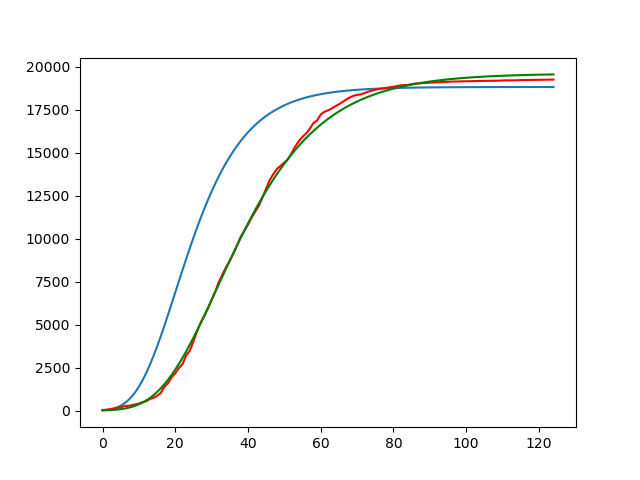

In [32]:
nll = lambda *args: log_likelihood_gompertz(*args)
dati = [x for x in casi]

t0 = -np.random.randint(0, 5)
ni = max(dati) + 500 * np.random.uniform(-0.9,0.9)
b = np.random.uniform(0.05, 0.1)
parametri = np.array([t0, ni, b])

soln = minimize(nll, parametri, args=(dati))
print(soln.x)
print(parametri)
t01, ni1, b1 = soln.x

modello, diff_modello = gompertz(N, t0, ni, b)
modello1, diff_modello = gompertz(N, t01, ni1, b1)

plt.figure()
plt.plot(modello)
plt.plot(dati, color='red')
plt.plot(modello1, color='green')

In [33]:
#distribuzione prob parametri è costante, lo è anche il logaritmo, lo si ignora per minimizzazione
'''
def log_prior(theta):
    t0, ni, b = theta
    if t0 <= 0 and 0.0 < ni and 0.0 < b < 1.0:
        return 0.0
    return -np.inf
'''

#log_probability = log_likelihood_gompertz + log_prior(=cost) = log_likelihood_gompertz
'''
def log_probability(dati, theta):
    lp = log_prior(theta)
    return lp + log_likelihood_gompertz(theta, dati)
'''
log_probability = log_likelihood_gompertz(parametri, dati)

In [51]:
#simulazione
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(dati))
sampler.run_mcmc(pos, 100, progress=True);

emcee: Exception while calling your likelihood function:
  params: [-4.25094280e+00  1.96198633e+04  6.35355116e-02]
  args: [33, 43, 71, 111, 151, 191, 263, 273, 307, 360, 407, 488, 543, 670, 744, 856, 1023, 1384, 1595, 1937, 2172, 2473, 2704, 3214, 3484, 4031, 4617, 5122, 5505, 5948, 6442, 6935, 7497, 7930, 8358, 8724, 9155, 9625, 10111, 10464, 10824, 11226, 11588, 11925, 12410, 12933, 13421, 13768, 14077, 14251, 14432, 14624, 14990, 15374, 15692, 15935, 16127, 16404, 16738, 16881, 17229, 17391, 17471, 17579, 17708, 17825, 17960, 18098, 18224, 18318, 18373, 18402, 18479, 18553, 18618, 18671, 18722, 18741, 18782, 18813, 18845, 18889, 18928, 18941, 18950, 18997, 19030, 19038, 19059, 19069, 19086, 19097, 19105, 19113, 19125, 19134, 19146, 19152, 19154, 19162, 19164, 19168, 19174, 19182, 19183, 19187, 19191, 19194, 19199, 19199, 19212, 19219, 19220, 19221, 19225, 19233, 19235, 19238, 19245, 19247, 19250, 19253, 19257, 19262, 19264]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Users\march\anaconda3\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: 'numpy.float64' object is not callable


TypeError: 'numpy.float64' object is not callable

<IPython.core.display.Javascript object>


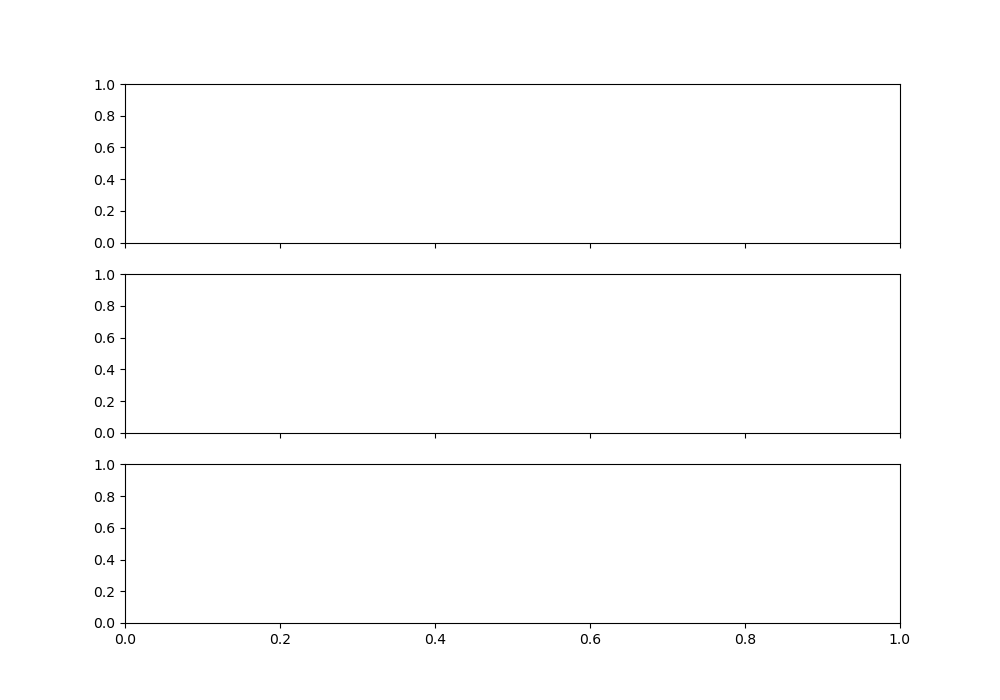

AttributeError: you must run the sampler with 'store == True' before accessing the results

In [49]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t0", "ni", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [48]:
sampler.run_mcmc?